## Bibliotek

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import fsolve

## Simulering

### IV-kurve og transkonduktans

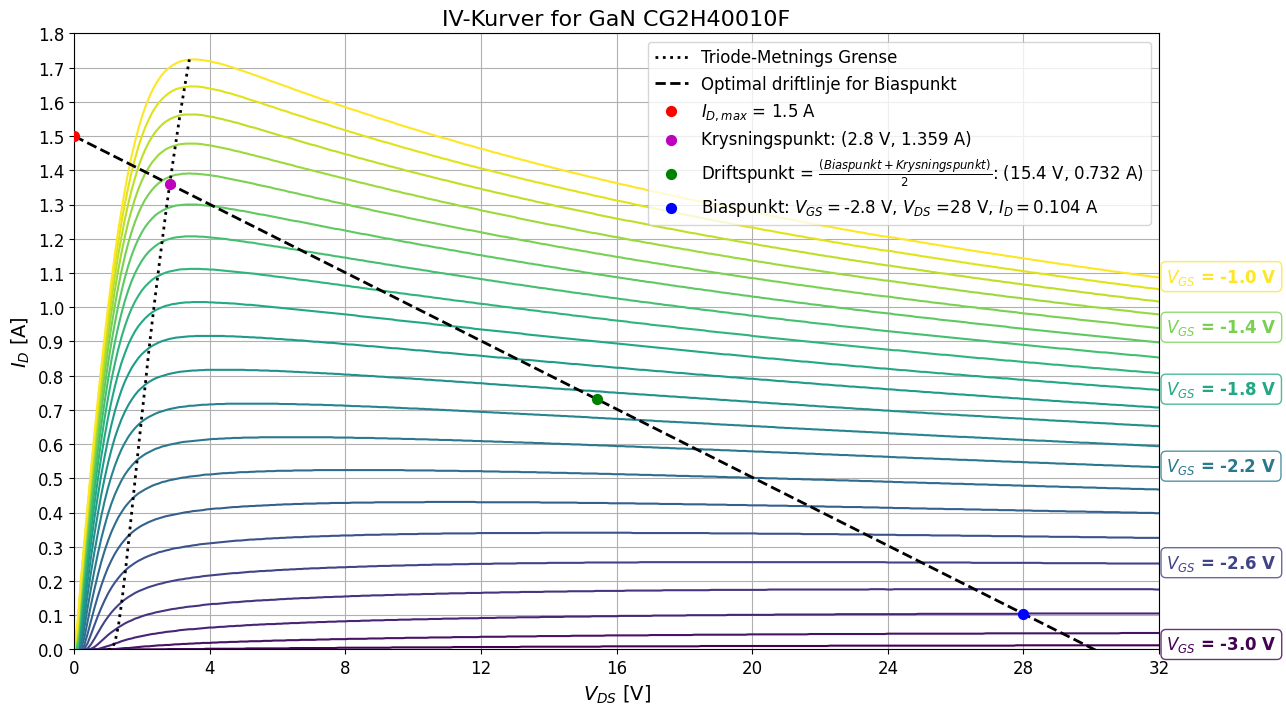

In [58]:
# Load IV data
IV_kurve01 = np.loadtxt('Data/Simulering/Transistorkarakteristikk/IV_kurve01.csv', delimiter=',', skiprows=16)
IV_kurve01 = pd.DataFrame(IV_kurve01, columns=['VGS', 'VDS', 'ID'])

Transkonduktans = np.loadtxt('Data/Simulering/Transistorkarakteristikk/Transkonduktans.csv', delimiter=',', skiprows=16)
Transkonduktans = pd.DataFrame(Transkonduktans, columns=['VGS', 'VDS', 'gm'])

# Create a colormap
unique_vgs = IV_kurve01['VGS'].unique()
IV_cmap = plt.get_cmap('viridis', len(unique_vgs))

# Define transistor parameters and bias point
Imax = 1.5

VDS_bias=28
VGS_bias= -2.8
I_bias = IV_kurve01[(IV_kurve01['VGS'] == VGS_bias) & (IV_kurve01['VDS'] == VDS_bias)]['ID'].values[0]

# Calculate the optimal load line
def last_linje(x):
    slope = (I_bias - Imax) / VDS_bias
    intercept = Imax
    return slope * x + intercept

x_driftlinje = np.linspace(0, 32, 100)
y_driftlinje = last_linje(x_driftlinje)

def calculate_vth(VGS):
    Vth_min = -4
    Vth_max = -4.4
    VGS_min = IV_kurve01['VGS'].min()
    VGS_max = IV_kurve01['VGS'].max()
    normalized_vgs = (VGS - VGS_min) / (VGS_max - VGS_min)
    return Vth_min + (Vth_max - Vth_min) * (normalized_vgs ** 2)

def triode_saturation_boundary(IV_data):
    boundary_points = {'VDS': [], 'ID': []}  # Store boundary points

    for VGS in IV_data['VGS'].unique():
        Vth = calculate_vth(VGS)  # Calculate Vth based on VGS
        VDS_sat = VGS - Vth  # Calculate VDS at saturation boundary
        if VDS_sat >= 0:  # Only consider positive VDS values
            try:
                # Find the ID corresponding to VGS and VDS_sat
                ID_value = IV_data[(IV_data['VGS'] == VGS) & (IV_data['VDS'] >= VDS_sat)]['ID'].values[0]
                boundary_points['VDS'].append(VDS_sat)
                boundary_points['ID'].append(ID_value)
            except IndexError:
                # In case the specific VDS_sat is not found in the data
                continue

    return boundary_points['VDS'], boundary_points['ID']

# Calculate the boundary points
x_boundary, y_boundary = triode_saturation_boundary(IV_kurve01)

# Define the function to find the intersection
def find_intersection(x_lastlinje, y_lastlinje, x_boundary, y_boundary):
    def equations(VDS):
        return np.interp(VDS, x_lastlinje, y_lastlinje) - np.interp(VDS, x_boundary, y_boundary)
    VDS_intersection = fsolve(equations, VDS_bias)[0]
    ID_intersection = np.interp(VDS_intersection, x_lastlinje, y_lastlinje)
    return VDS_intersection, ID_intersection

# Find the intersection point
VDS_intersection, ID_intersection = find_intersection(x_driftlinje, y_driftlinje, x_boundary, y_boundary)
VDS_operating = (VDS_bias + VDS_intersection) / 2
ID_operating = (I_bias + ID_intersection) / 2

# Plot IV curves for different VGS values
plt.figure(figsize=(14, 8))
for i, vgs in enumerate(unique_vgs):
    subset = IV_kurve01[IV_kurve01['VGS'] == vgs]
    plt.plot(subset['VDS'], subset['ID'], color=IV_cmap(i))
    # Annotate the endpoint of each curve with the VGS value
    if i % 4 == 0:
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=IV_cmap(i))
        plt.annotate('$V_{GS}$ = '+f'{vgs} V', xy=(subset['VDS'].iloc[-1], subset['ID'].iloc[-1]),
                 xytext=(5, -3), textcoords='offset points', bbox=props, fontsize=12, fontweight='bold', color=IV_cmap(i))

plt.plot(x_boundary, y_boundary , color='k', linestyle=':', linewidth=2, label='Triode-Metnings Grense')
plt.plot(x_driftlinje, y_driftlinje, color='k', linestyle='--', linewidth=2,label='Optimal driftlinje for Biaspunkt')  

plt.scatter(0, Imax, color='r', s=50, zorder=10, label='$I_{D,max}$ = 1.5 A')
plt.scatter(VDS_intersection, ID_intersection, color='m', s=50, zorder=10, label='Krysningspunkt: '+f'({VDS_intersection:.1f} V, {ID_intersection:.3f} A)')
plt.scatter(VDS_operating, ID_operating, color='g', s=50, zorder=10, label=r'Driftspunkt = $\frac{(Biaspunkt + Krysningspunkt)}{2}$: '+f'({VDS_operating:.1f} V, {ID_operating:.3f} A)')
plt.scatter(VDS_bias, I_bias, color='b', s=50, zorder=10, label='Biaspunkt: $V_{GS} = $'+f'{VGS_bias}'+' V, $V_{DS}$ ='+f'{VDS_bias} V, ' + f'$I_D = {I_bias:.3f}$ A')

plt.xlabel('$V_{DS}$ [V]', fontsize=14)
plt.ylabel('$I_D$ [A]', fontsize=14)
plt.title('IV-Kurver for GaN CG2H40010F', fontsize=16)

plt.xlim(0, 32)
plt.ylim(0, 1.5)
plt.yticks(np.arange(0, 1.8 + 0.1, 0.1), fontsize=12)
plt.xticks(np.arange(0, 32.1, 4), fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


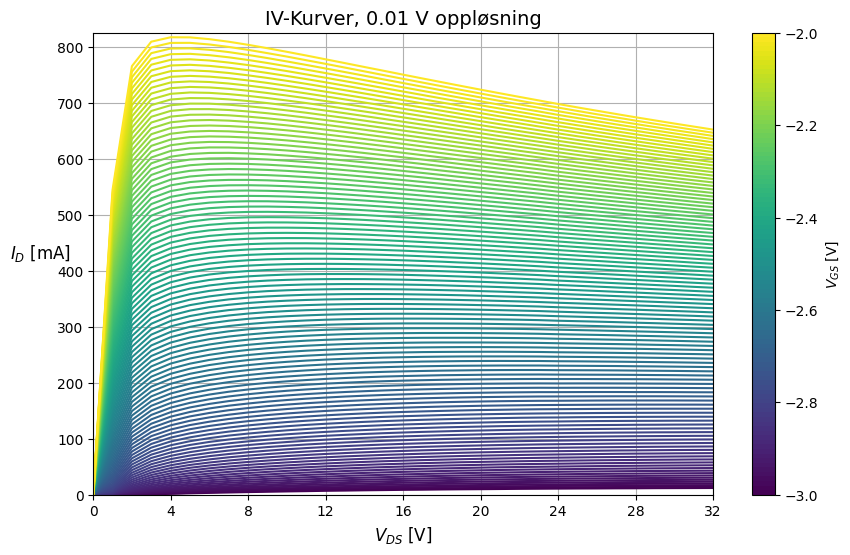

In [59]:
# Load IV data
IV_kurve = np.loadtxt('Data/Simulering/Transistorkarakteristikk/IV_kurve.csv', delimiter=',', skiprows=17)
IV_kurve = pd.DataFrame(IV_kurve, columns=['VGS', 'VDS', 'ID'])

# Convert current from A to mA
IV_kurve['ID'] = IV_kurve['ID'] * 1000

# Create a colormap
unique_vgs = IV_kurve['VGS'].unique()
norm = mcolors.Normalize(vmin=unique_vgs.min(), vmax=unique_vgs.max())  # Normalize the VGS values
IV_cmap = plt.get_cmap('viridis', len(unique_vgs))

# Plot IV curves for different VGS values
fig, ax = plt.subplots(figsize=(10, 6))

for i, vgs in enumerate(unique_vgs):
    subset = IV_kurve[IV_kurve['VGS'] == vgs]
    ax.plot(subset['VDS'], subset['ID'], color=IV_cmap(norm(vgs)))  # Use normalized VGS for color

# Add colorbar for the VGS values
sm = cm.ScalarMappable(cmap=IV_cmap, norm=norm)  # Create ScalarMappable for the colorbar
sm.set_array([])  # Set array to allow ScalarMappable to work
cbar = plt.colorbar(sm, ax=ax, label='$V_{GS}$ [V]')  # Add the colorbar linked to the plot

# Set x-ticks and labels
ax.set_xticks(np.arange(0, 32.1, 4))
ax.set_xlabel('$V_{DS}$ [V]', fontsize=12)
ax.set_ylabel('$I_{D}$ [mA]', fontsize=12, labelpad=12, rotation=0)
ax.set_title('IV-Kurver, 0.01 V oppløsning', fontsize=14)
ax.set_xlim(0, 32)
ax.set_ylim(0, 825)

# Add grid and show the plot
ax.grid(True)
plt.show()


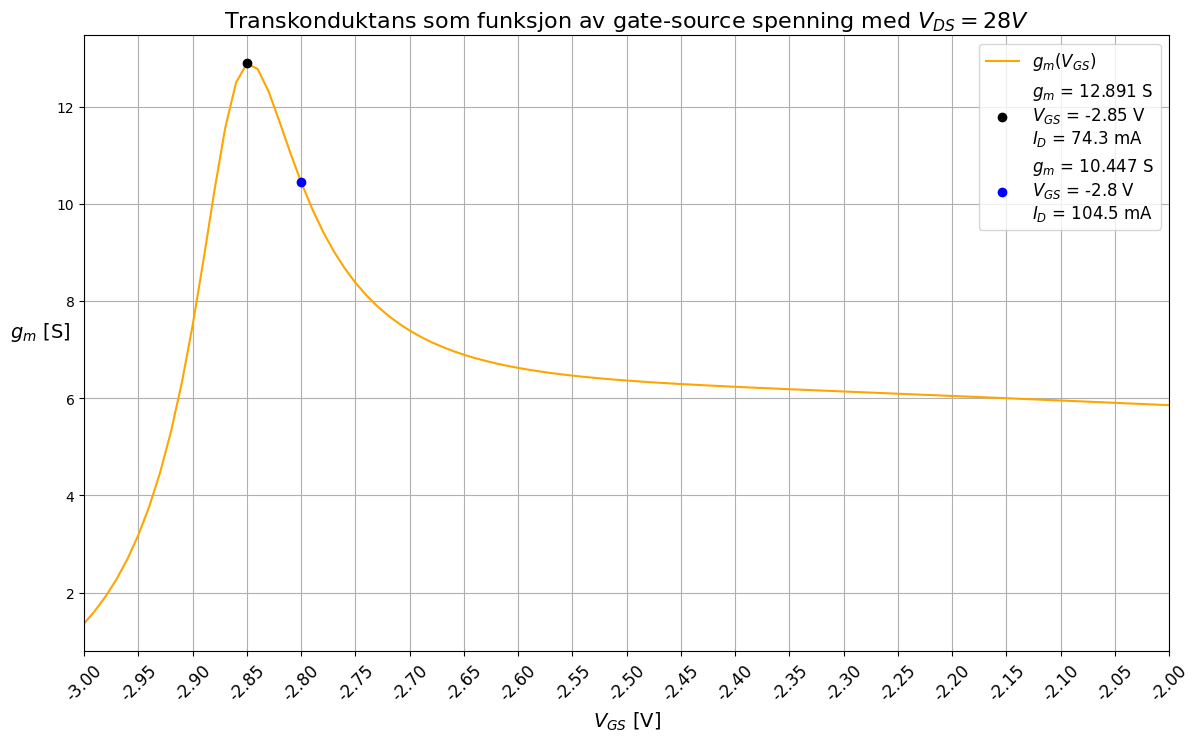

In [60]:
# Load transkonduktans data
Transkonduktans28V = np.loadtxt('Data/Simulering/Transistorkarakteristikk/Transkonduktans28V.csv', delimiter=',', skiprows=11)
Transkonduktans28V = pd.DataFrame(Transkonduktans28V, columns=['VGS', 'Gm'])

# Find the maximum gm value and corresponding VGS
max_gm_idx = Transkonduktans28V['Gm'].idxmax()
max_gm = Transkonduktans28V.loc[max_gm_idx]
max_ID = IV_kurve[IV_kurve['VGS'] == max_gm['VGS']]['ID'].max()

# Find gm and ID for VGS = -2.8
gm_2_8 = Transkonduktans28V[Transkonduktans28V['VGS'] == -2.8]['Gm'].values[0]
id_2_8 = IV_kurve[(IV_kurve['VGS'] == -2.8) & (IV_kurve['VDS'] == 28)]['ID'].values[0]

# Plot the transconductance curve
plt.figure(figsize=(14, 8))
plt.plot(Transkonduktans28V['VGS'], Transkonduktans28V['Gm'], color='orange', label=f'$g_m(V_{{GS}})$')

# Highlight the maximum gm point
plt.scatter(max_gm['VGS'], max_gm['Gm'], marker='o', color='k', label=f'$g_m$ = {max_gm["Gm"]:.3f} S\n$V_{{GS}}$ = {max_gm["VGS"]:.2f} V \n$I_D$ = {max_ID:.1f} mA', zorder=5)

# Highlight the gm point for VGS = -2.8
plt.scatter(-2.8, gm_2_8, marker='o', color='b', label=f'$g_m$ = {gm_2_8:.3f} S\n$V_{{GS}}$ = -2.8 V \n$I_D$ = {id_2_8:.1f} mA', zorder=5)

# Set plot labels and title
plt.xlabel('$V_{GS}$ [V]', fontsize=14)
plt.ylabel('$g_m$ [S]', fontsize=14, labelpad=12, rotation=0)
plt.title('Transkonduktans som funksjon av gate-source spenning med $V_{DS} = 28 V$', fontsize=16)
plt.grid(True)
plt.xticks(np.arange(-3, -2+0.01, 0.05), rotation=45, fontsize=12)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(fontsize=12)
plt.xlim(-3, -2)
plt.show()

### S21 og stabilitet

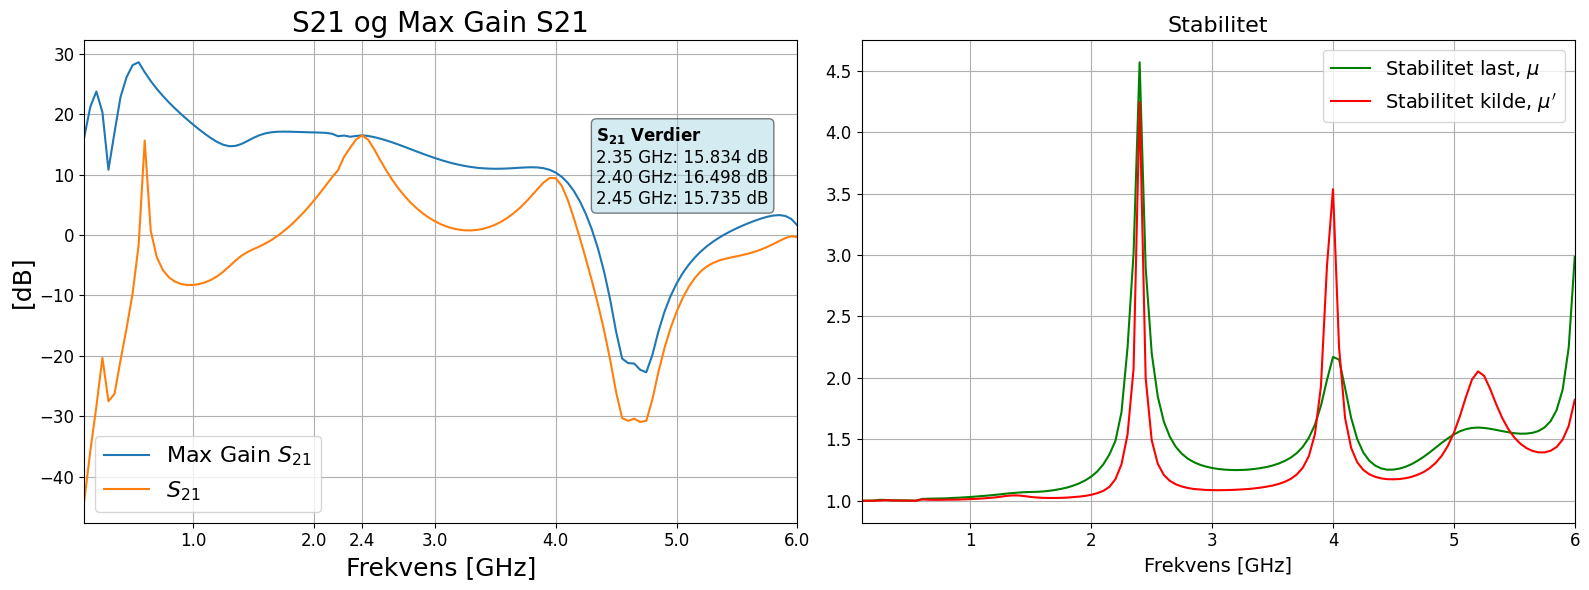

In [61]:
stabilitet = np.loadtxt('Data/Simulering/S_param/stab_factor.csv', delimiter=',', skiprows=16)
stabilitet = pd.DataFrame(stabilitet, columns=['Frekvens', 'Stabilitet last', 'Stabilitet kilde'])

MAG_S21 = np.loadtxt('Data/Simulering/S_param/MAG_S21.csv', delimiter=',', skiprows=16)
MAG_S21 = pd.DataFrame(MAG_S21, columns=['Frekvens', 'Mag', 'S21'])

stabilitet['Frekvens'] = stabilitet['Frekvens'] / 1e9
MAG_S21['Frekvens'] = MAG_S21['Frekvens'] / 1e9

freqs = [2.35, 2.40, 2.45]
s21_values = {freq: MAG_S21.loc[MAG_S21['Frekvens'] == freq, 'S21'].values[0] for freq in freqs}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot MAG_S21
axs[0].plot(MAG_S21['Frekvens'], MAG_S21['Mag'], label=r'Max Gain $S_{21}$')
axs[0].plot(MAG_S21['Frekvens'], MAG_S21['S21'], label=r'$S_{21}$')
axs[0].set_xlabel('Frekvens [GHz]', fontsize=18)
axs[0].set_ylabel('[dB]', fontsize=18)
axs[0].legend(fontsize=16)
axs[0].grid(True)
axs[0].title.set_text('S21 og Max Gain S21')
axs[0].title.set_fontsize(20)

# Set x-ticks to ensure 2.4 GHz is included
xticks = list(axs[0].get_xticks())  # Get current x-ticks
if 2.4 not in xticks:
    xticks.append(2.4)  # Add 2.4 GHz if it's not already in the list
xticks.sort()  # Sort the ticks
axs[0].set_xticks(xticks)  # Set the new x-ticks
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(0.1, 6)

# Plot Stabilitet last and Stabilitet kilde
axs[1].plot(stabilitet['Frekvens'], stabilitet['Stabilitet last'], color='g', label=r'Stabilitet last, $\mu$')
axs[1].plot(stabilitet['Frekvens'], stabilitet['Stabilitet kilde'], color='r', label=r'Stabilitet kilde, $\mu^{\prime}$')
axs[1].set_xlabel('Frekvens [GHz]', fontsize=14)
axs[1].legend(fontsize=14)
axs[1].grid(True)
axs[1].title.set_text('Stabilitet')
axs[1].title.set_fontsize(16)
axs[1].set_xlim(0.1, 6)

# Annotate the S21 values in a box right under the legend
textstr = r'$\mathbf{S_{21}\ Verdier}$' + '\n' + '\n'.join([f'{freq:.2f} GHz: {s21_values[freq]:.3f} dB' for freq in freqs])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
axs[0].text(0.96, 0.825, textstr, transform=axs[0].transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props, multialignment='left')

# Increase tick label size
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)

# Show plot
plt.tight_layout()
plt.show()

### 1-tone HB

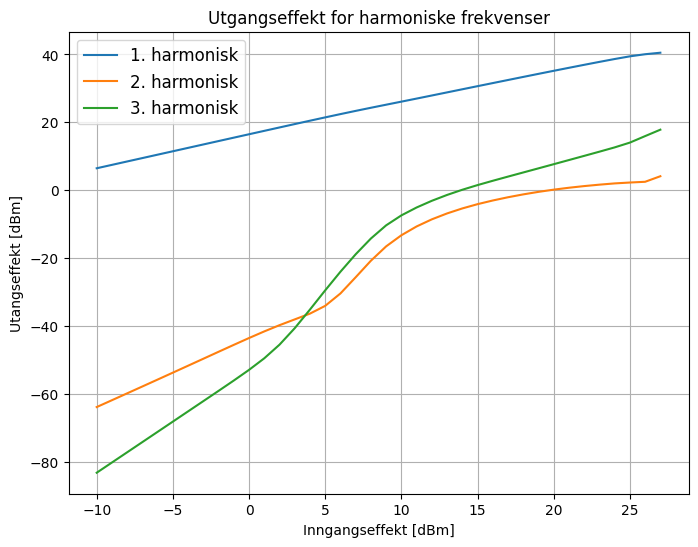

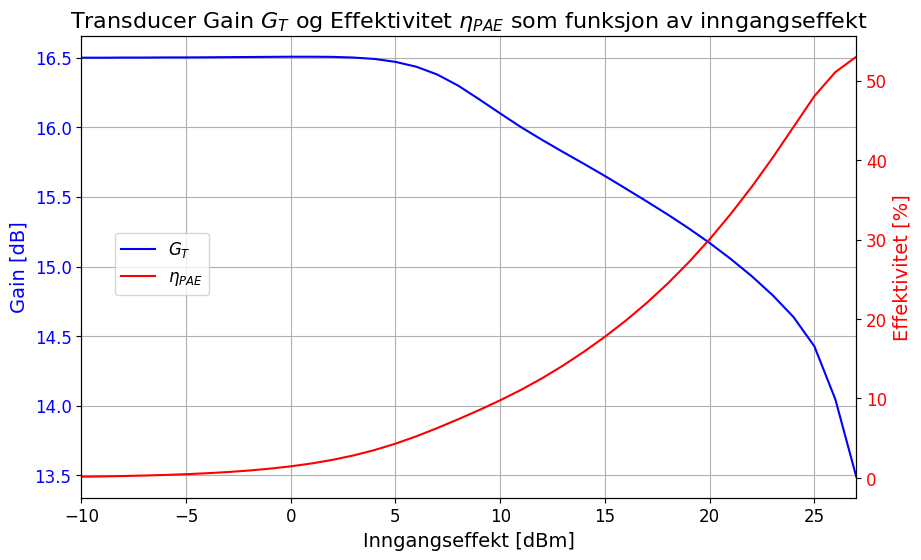

In [62]:
P_ut = np.loadtxt('Data/Simulering/HB_1Tone/Put.csv', delimiter=',',skiprows=21)
P_ut = pd.DataFrame(P_ut, columns=['P_in', 'P_ut1', 'P_ut2', 'P_ut3'])

TransGain = np.loadtxt('Data/Simulering/HB_1Tone/TransGain.csv', delimiter=',',skiprows=11)
TransGain = pd.DataFrame(TransGain, columns=['P_in', 'Gain'])

Effektivitet = np.loadtxt('Data/Simulering/HB_1Tone/Effektivitet.csv', delimiter=',',skiprows=21)
Effektivitet = pd.DataFrame(Effektivitet, columns=['P_in', 'DrainEff', 'TotalEff', 'PAE'])


plt.figure(figsize=(8, 6))
plt.plot(P_ut['P_in'], P_ut['P_ut1'], label='1. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut2'], label='2. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut3'], label='3. harmonisk')
plt.xlabel('Inngangseffekt [dBm]')
plt.ylabel('Utangseffekt [dBm]')
plt.legend(fontsize=12)
plt.title('Utgangseffekt for harmoniske frekvenser')
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
ax1.plot(TransGain['P_in'], TransGain['Gain'], 'b-', label='$G_T$')
ax1.set_xlabel('Inngangseffekt [dBm]', fontsize=14)
ax1.set_ylabel('Gain [dB]', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_title(r'Transducer Gain $G_T$ og Effektivitet $\eta_{PAE}$ som funksjon av inngangseffekt', fontsize=16)
ax1.grid(True)
ax1.set_xlim(-10, 27)

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(Effektivitet['P_in'], Effektivitet['PAE'], 'r-', label=r'$\eta_{PAE}$')
ax2.set_ylabel('Effektivitet [%]', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r', labelsize=12)

# Adding legend for the second y-axis
fig.legend(loc='center left', bbox_to_anchor=(0.15, 0.5), fontsize=12)

plt.show()


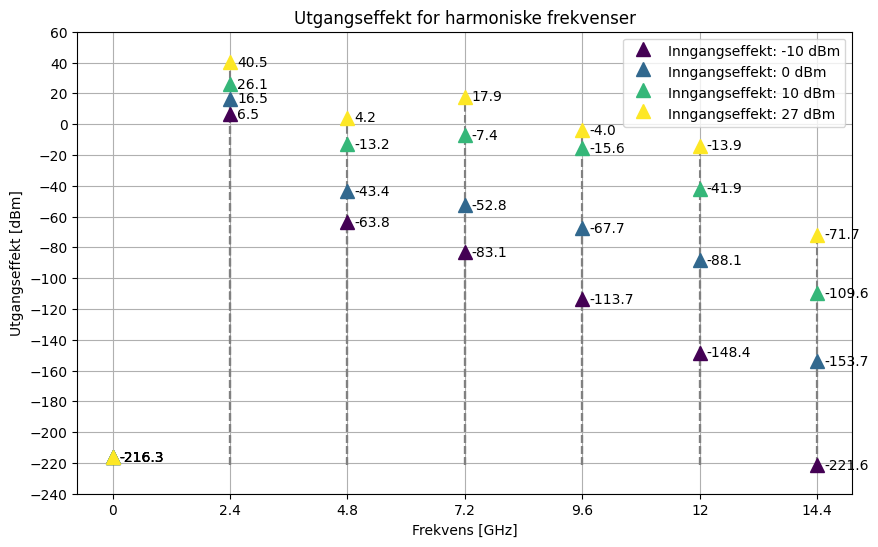

In [63]:
# Load the data
Spektrum = np.loadtxt('Data/Simulering/HB_1Tone/Spektrum1Tone.csv', delimiter=',', skiprows=16)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(Spektrum, columns=['P_in', 'Frequency', 'Value'])

# Define the harmonics of 2.4 GHz
harmonic_frequencies = [0, 2.4, 4.8, 7.2, 9.6, 12, 14.4]  # GHz

# Initialize a new DataFrame to store the reshaped data
Spektrum1Tone = pd.DataFrame(columns=['P_in', 'DC', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6'])

# Group by P_in and reshape the data
for p_in, group in df.groupby('P_in'):
    row = [p_in] + [np.nan] * len(harmonic_frequencies)
    for i, harmonic in enumerate(harmonic_frequencies):
        value = group.loc[group['Frequency'] == harmonic * 1e9, 'Value'].values
        row[i + 1] = value[0] if len(value) > 0 else np.nan
    Spektrum1Tone.loc[len(Spektrum1Tone)] = row


min_value = Spektrum1Tone.iloc[:, 1:].min().min()
max_value = Spektrum1Tone.iloc[:, 1:].max().max()
step=20

# Desired input power values
Power_values = [-10, 0, 10, 27]  # dBm
cmap = plt.get_cmap('viridis', len(Power_values))

# Plot the spectral lines at the desired input power
plt.figure(figsize=(10, 6))
for i, Power in enumerate(Power_values):
    idx = (Spektrum1Tone['P_in'] == Power)
    markerline, stemlines, baseline = plt.stem(
        harmonic_frequencies, 
        Spektrum1Tone.loc[idx].values[0][1:], 
        linefmt='--', 
        markerfmt='^', 
        basefmt=' ', 
        label=f'Inngangseffekt: {Power} dBm',
        bottom=min_value,
    )
    plt.setp(markerline, 'zorder', 3, 'markersize', 10, 'color', cmap(i))  # Set marker z-order, size, and color
    plt.setp(stemlines, 'zorder', 2, 'color', 'gray')   # Set stem line z-order and color
    plt.setp(baseline, 'zorder', 1)  # Set baseline z-order

    for x, y in zip(harmonic_frequencies, Spektrum1Tone.loc[idx].values[0][1:]):
        plt.annotate(f'{y:.1f}', xy=(x, y), xytext=(5, -3), textcoords='offset points', fontsize=10, color='black')

plt.xticks(harmonic_frequencies, [f'{freq}' for freq in harmonic_frequencies]) 
plt.yticks(np.arange(np.floor(min_value / step) * step, np.ceil(max_value / step) * step + 1, step))
plt.xlabel('Frekvens [GHz]')
plt.ylabel('Utgangseffekt [dBm]')
plt.title('Utgangseffekt for harmoniske frekvenser')
plt.legend()
plt.grid(True)
plt.show()

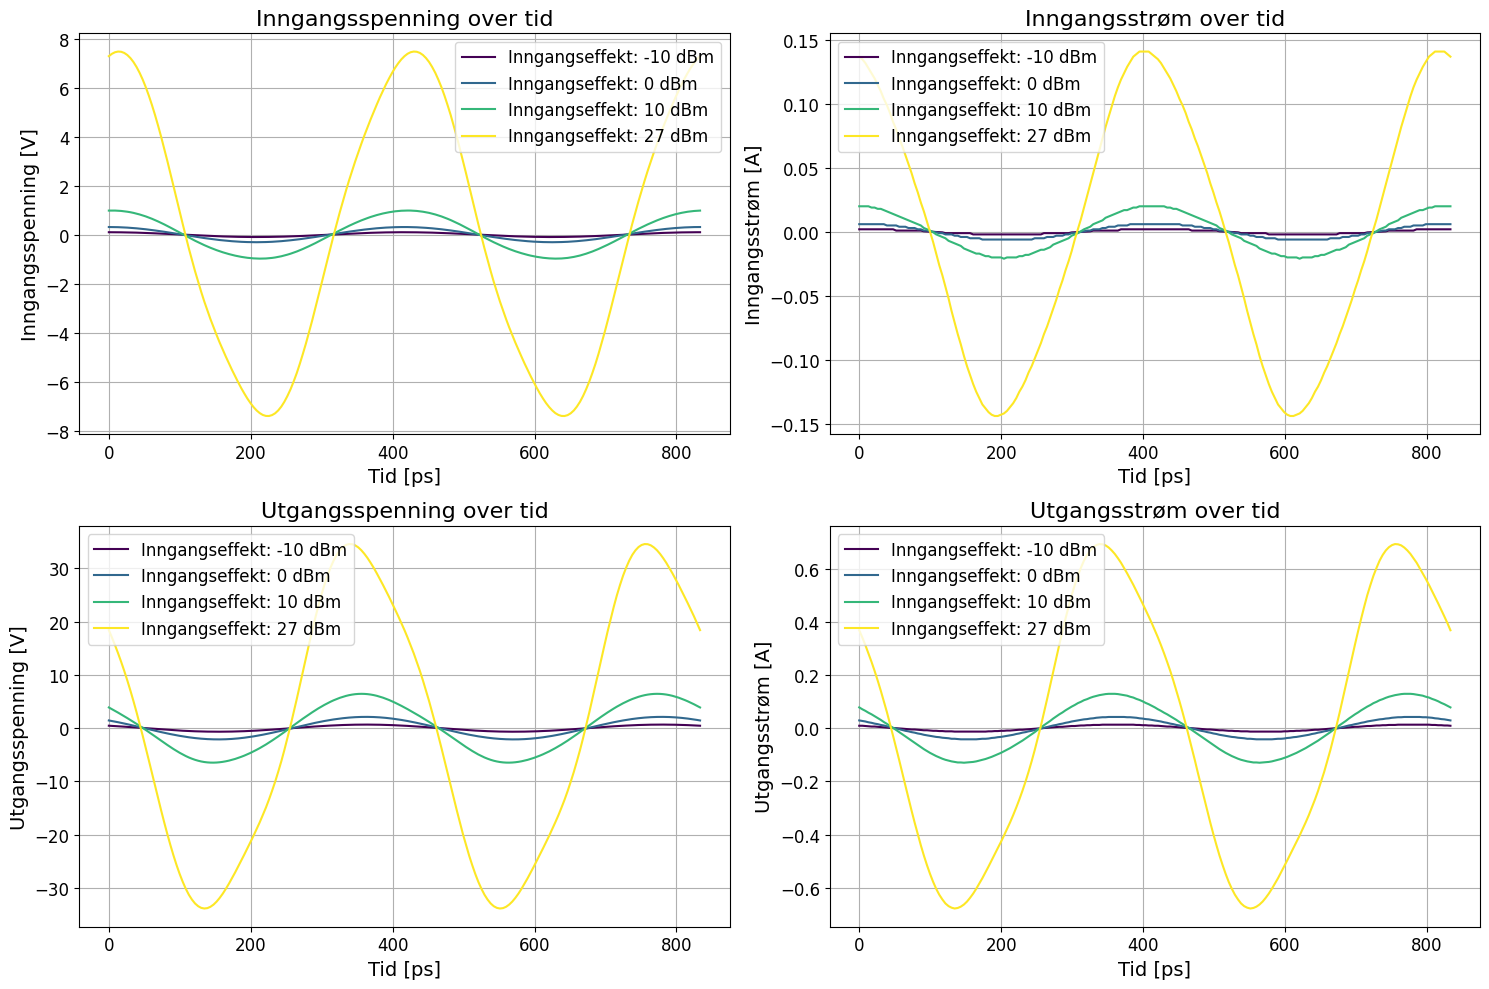

In [64]:
# Load the data
Tidsserier1Tone = np.loadtxt('Data/Simulering/HB_1Tone/Tidsserier1Tone.csv', delimiter=',', skiprows=31)
Tidsserier1Tone = pd.DataFrame(Tidsserier1Tone, columns=['P_in', 'Time', 'V_in', 'I_in', 'V_out', 'I_out'])

# Convert Time to picoseconds
Tidsserier1Tone['Time'] = Tidsserier1Tone['Time'] * 1e12

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot V_in versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[0, 0].plot(subset['Time'], subset['V_in'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[0, 0].set_xlabel('Tid [ps]', fontsize=14)
axs[0, 0].set_ylabel('Inngangsspenning [V]', fontsize=14)
axs[0, 0].set_title('Inngangsspenning over tid', fontsize=16)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)

# Plot I_in versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[0, 1].plot(subset['Time'], subset['I_in'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[0, 1].set_xlabel('Tid [ps]', fontsize=14)
axs[0, 1].set_ylabel('Inngangsstrøm [A]', fontsize=14)
axs[0, 1].set_title('Inngangsstrøm over tid', fontsize=16)
axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(True)

# Plot V_out versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[1, 0].plot(subset['Time'], subset['V_out'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[1, 0].set_xlabel('Tid [ps]', fontsize=14)
axs[1, 0].set_ylabel('Utgangsspenning [V]', fontsize=14)
axs[1, 0].set_title('Utgangsspenning over tid', fontsize=16)
axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(True)

# Plot I_out versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[1, 1].plot(subset['Time'], subset['I_out'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[1, 1].set_xlabel('Tid [ps]', fontsize=14)
axs[1, 1].set_ylabel('Utgangsstrøm [A]', fontsize=14)
axs[1, 1].set_title('Utgangsstrøm over tid', fontsize=16)
axs[1, 1].legend(fontsize=12)
axs[1, 1].grid(True)

# Increase tick label size
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

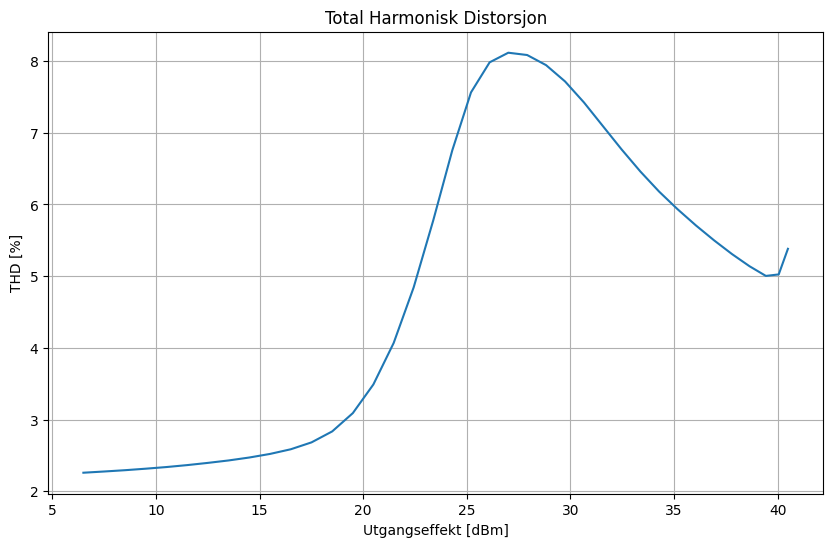

In [65]:
THD = np.loadtxt('Data/Simulering/HB_1Tone/THD1Tone.csv', delimiter=',', skiprows=11)
THD = pd.DataFrame(THD, columns=['P_ut', 'THD'])

plt.figure(figsize=(10, 6))
plt.plot(THD['P_ut'], THD['THD'])
plt.xlabel('Utgangseffekt [dBm]')
plt.ylabel('THD [%]')
plt.title('Total Harmonisk Distorsjon')
plt.grid(True)

### 2-Tone HB

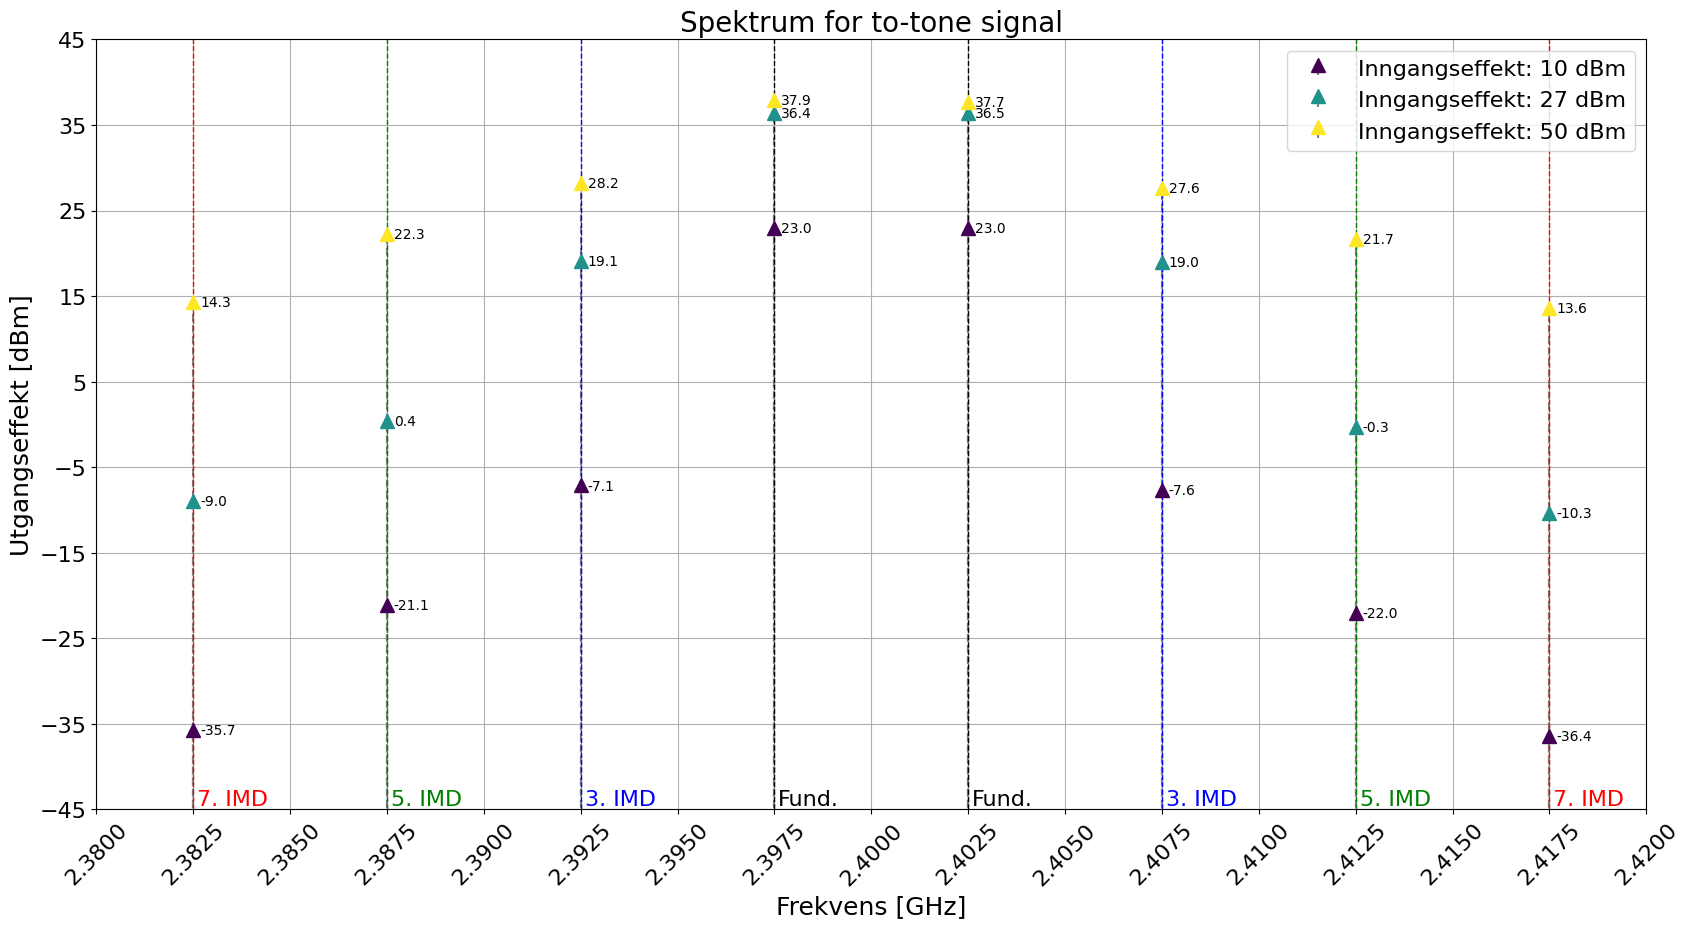

In [66]:
# Load the data
Spektrum2Tone = np.loadtxt('Data/Simulering/HB_2Tone/Spektrum2Tone.csv', delimiter=',', skiprows=16)
Spektrum2Tone = pd.DataFrame(Spektrum2Tone, columns=['RFPower', 'Frequency', 'Value'])

Fund_freqs = [2.3975, 2.4025]
imd_3rd = [2 * Fund_freqs[0] - Fund_freqs[1], 2 * Fund_freqs[1] - Fund_freqs[0]]
imd_5th = [3 * Fund_freqs[0] - 2 * Fund_freqs[1], 3 * Fund_freqs[1] - 2 * Fund_freqs[0]]
imd_7th = [4 * Fund_freqs[0] - 3 * Fund_freqs[1], 4 * Fund_freqs[1] - 3 * Fund_freqs[0]]

# Slice data to only include frequencies between 2.3 and 2.5 GHz and convert to GHz
Spektrum2Tone_Fund = Spektrum2Tone[(Spektrum2Tone['Frequency'] < 2.5e9) & (Spektrum2Tone['Frequency'] > 2.3e9)].copy()
Spektrum2Tone_Fund.loc[:, 'Frequency'] = Spektrum2Tone_Fund['Frequency'] / 1e9

Power_values = [10, 27, 50]  # dBm
cmap = plt.get_cmap('viridis', len(Power_values))

plt.figure(figsize=(20, 10))
for i, Power in enumerate(Power_values):
    idx = (Spektrum2Tone_Fund['RFPower'] == Power)
    freqs = Spektrum2Tone_Fund[idx]['Frequency'].values
    values = Spektrum2Tone_Fund[idx]['Value'].values
    
    markerline, stemlines, baseline = plt.stem(
        freqs, 
        values, 
        linefmt='--', 
        markerfmt='^', 
        basefmt=' ', 
        label=f'Inngangseffekt: {Power} dBm',
        bottom=min_value
    )
    plt.setp(markerline, 'zorder', 3, 'markersize', 10, 'color', cmap(i))  # Set marker z-order, size, and color
    plt.setp(stemlines, 'zorder', 2, 'color', 'gray')   # Set stem line z-order and color
    plt.setp(baseline, 'zorder', 1)  # Set baseline z-order

    for x, y in zip(freqs, values):
        plt.annotate(f'{y:.1f}', xy=(x, y), xytext=(5, -3), textcoords='offset points', fontsize=10, color='black')

# Annotate IMD products with vertical lines and text labels
for fund in Fund_freqs:
    plt.axvline(x=fund, color='k', linestyle='--', linewidth=1)
    plt.text(fund+0.0001, -45, 'Fund.', verticalalignment='bottom', fontsize=16)

for imd_freq in imd_3rd:
    plt.axvline(x=imd_freq, color='b', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '3. IMD', verticalalignment='bottom', fontsize=16, color='b')

for imd_freq in imd_5th:
    plt.axvline(x=imd_freq, color='g', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '5. IMD', verticalalignment='bottom', fontsize=16, color='g')

for imd_freq in imd_7th:
    plt.axvline(x=imd_freq, color='r', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '7. IMD', verticalalignment='bottom', fontsize=16, color='r')

plt.xlabel('Frekvens [GHz]', fontsize=18)
plt.ylabel('Utgangseffekt [dBm]', fontsize=18)
plt.title('Spektrum for to-tone signal', fontsize=20)
plt.legend(fontsize=16)

plt.xlim(2.38, 2.42)
plt.xticks(np.arange(2.38, 2.42 + 0.0001, 0.0025), fontsize=16, rotation=45)
plt.ylim(-45, 40)
plt.yticks(np.arange(-45, 40 + 10, 10), fontsize=16)

plt.grid(True)
plt.show()

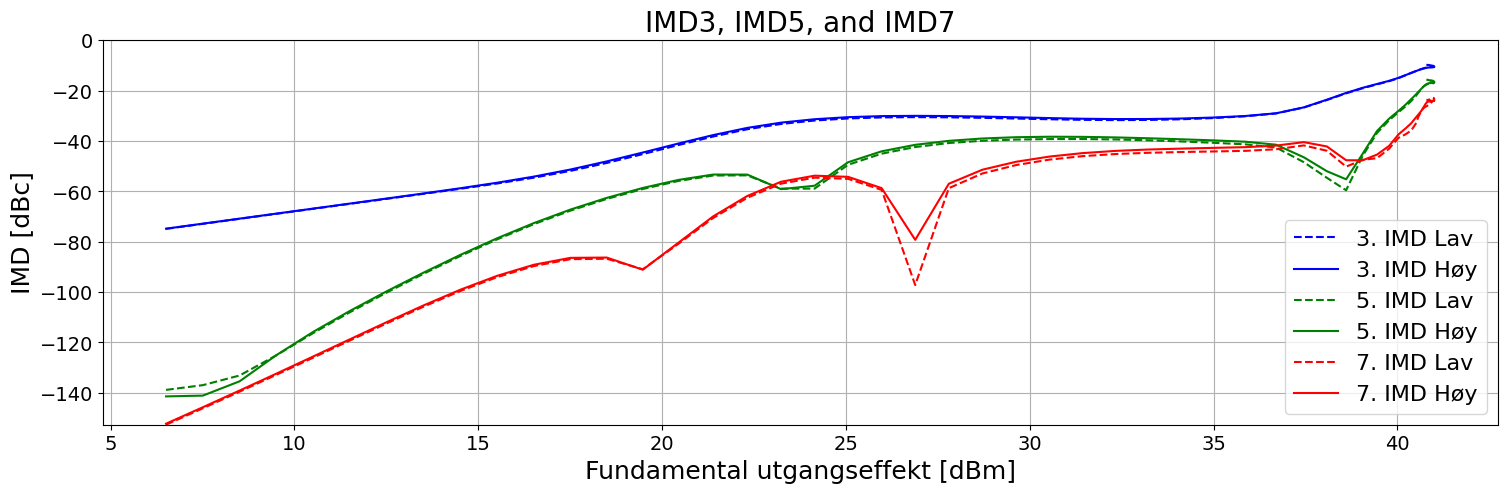

In [67]:
IMD3 = np.loadtxt('Data/Simulering/HB_2Tone/IMD3.csv', delimiter=',', skiprows=16)
IMD3 = pd.DataFrame(IMD3, columns=['P_out_fund', 'IMD3_low', 'IMD3_high'])

IMD5 = np.loadtxt('Data/Simulering/HB_2Tone/IMD5.csv', delimiter=',', skiprows=16)
IMD5 = pd.DataFrame(IMD5, columns=['P_out_fund', 'IMD5_low', 'IMD5_high'])

IMD7 = np.loadtxt('Data/Simulering/HB_2Tone/IMD7.csv', delimiter=',', skiprows=16)
IMD7 = pd.DataFrame(IMD7, columns=['P_out_fund', 'IMD7_low', 'IMD7_high'])

# Determine common y-axis limits
y_min = min(IMD3[['IMD3_low', 'IMD3_high']].min().min(), IMD5[['IMD5_low', 'IMD5_high']].min().min(), IMD7[['IMD7_low', 'IMD7_high']].min().min())
y_max = max(IMD3[['IMD3_low', 'IMD3_high']].max().max(), IMD5[['IMD5_low', 'IMD5_high']].max().max(), IMD7[['IMD7_low', 'IMD7_high']].max().max()) +10

plt.figure(figsize=(18, 5))

# Plot IMD3
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_low'], 'b--', label='3. IMD Lav')
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_high'], 'b-', label='3. IMD Høy')

# Plot IMD5
plt.plot(IMD5['P_out_fund'], IMD5['IMD5_low'], 'g--', label='5. IMD Lav')
plt.plot(IMD5['P_out_fund'], IMD5['IMD5_high'], 'g-', label='5. IMD Høy')

# Plot IMD7
plt.plot(IMD7['P_out_fund'], IMD7['IMD7_low'], 'r--', label='7. IMD Lav')
plt.plot(IMD7['P_out_fund'], IMD7['IMD7_high'], 'r-', label='7. IMD Høy')

# Set labels and title
plt.xlabel('Fundamental utgangseffekt [dBm]', fontsize=18)
plt.ylabel('IMD [dBc]', fontsize=18)
plt.title('IMD3, IMD5, and IMD7', fontsize=20)
plt.ylim(y_min, y_max)

# Add legend
plt.legend(fontsize=16)

# Add grid
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

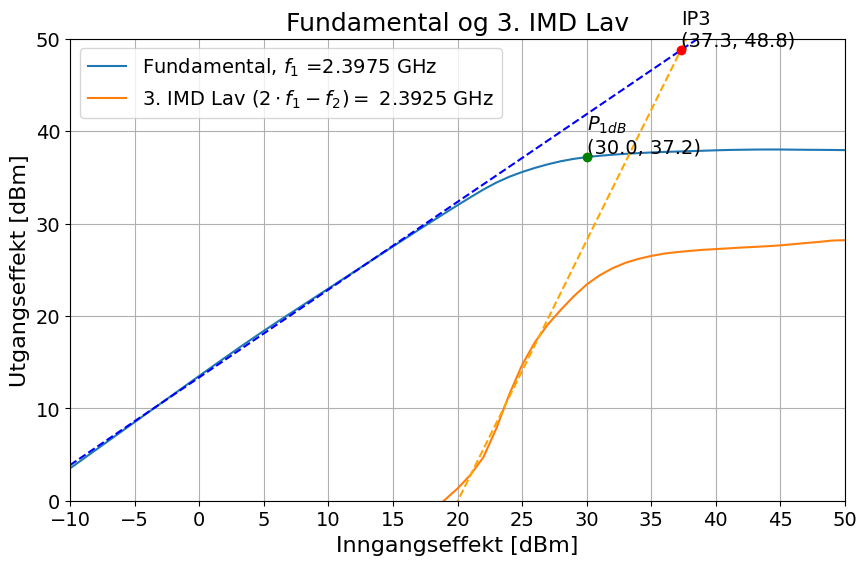

In [68]:
# Load the data
Put_fund_3rd_low = np.loadtxt('Data/Simulering/HB_2Tone/Put_fund_3rd_low.csv', delimiter=',', skiprows=16)
Put_fund_3rd_low = pd.DataFrame(Put_fund_3rd_low, columns=['RFPower', 'Pfund_low', 'P3rd_low'])

# Define the RFPower range for the polynomial fit of the fundamental
rfpower_min_fund = -10  # Minimum RFPower value for the fundamental fit
rfpower_max_fund = 20  # Maximum RFPower value for the fundamental fit

# Define the RFPower range for the polynomial fit of the 3rd IMD
rfpower_min_imd3 = 22.5  # Minimum RFPower value for the 3rd IMD fit
rfpower_max_imd3 = 27.5  # Maximum RFPower value for the 3rd IMD fit

# Filter the data based on the specified RFPower ranges
filtered_data_fund = Put_fund_3rd_low[(Put_fund_3rd_low['RFPower'] >= rfpower_min_fund) & (Put_fund_3rd_low['RFPower'] <= rfpower_max_fund)]
filtered_data_imd3 = Put_fund_3rd_low[(Put_fund_3rd_low['RFPower'] >= rfpower_min_imd3) & (Put_fund_3rd_low['RFPower'] <= rfpower_max_imd3)]

# Calculate the linear fit for the fundamental and 3rd IMD within the specified ranges
fund_fit = np.polyfit(filtered_data_fund['RFPower'], filtered_data_fund['Pfund_low'], 1)
imd3_fit = np.polyfit(filtered_data_imd3['RFPower'], filtered_data_imd3['P3rd_low'], 1)

# Calculate the intersection point (IP3)
ip3_x = (fund_fit[1] - imd3_fit[1]) / (imd3_fit[0] - fund_fit[0])
ip3_y = np.polyval(fund_fit, ip3_x)

# Calculate the 1dB compression point (P1dB)
p1db_x = Put_fund_3rd_low['RFPower'][np.argmax(Put_fund_3rd_low['Pfund_low'] >= (Put_fund_3rd_low['Pfund_low'].max() - 1))]
p1db_y = Put_fund_3rd_low['Pfund_low'][np.argmax(Put_fund_3rd_low['Pfund_low'] >= (Put_fund_3rd_low['Pfund_low'].max() - 1))]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(Put_fund_3rd_low['RFPower'], Put_fund_3rd_low['Pfund_low'], label='Fundamental, $f_1$ =' + f'{Fund_freqs[0]} GHz')
plt.plot(Put_fund_3rd_low['RFPower'], Put_fund_3rd_low['P3rd_low'], label=r'3. IMD Lav $(2\cdot f_1 -f_2) =$ ' + f'{imd_3rd[0]:.4f} GHz')

# Plot the linear fits
plt.plot(Put_fund_3rd_low['RFPower'], np.polyval(fund_fit, Put_fund_3rd_low['RFPower']), '--', color='b')
plt.plot(Put_fund_3rd_low['RFPower'], np.polyval(imd3_fit, Put_fund_3rd_low['RFPower']), '--', color='orange')

# Plot the IP3 point
plt.scatter(ip3_x, ip3_y, color='red', zorder=5)
plt.text(ip3_x, ip3_y, f'IP3\n({ip3_x:.1f}, {ip3_y:.1f})', fontsize=14, verticalalignment='bottom')

# Plot the 1dB compression point
plt.scatter(p1db_x, p1db_y, color='green', zorder=5)
plt.text(p1db_x, p1db_y, '$P_{1dB}$'+f'\n({p1db_x:.1f}, {p1db_y:.1f})', fontsize=14, verticalalignment='bottom')

plt.xlabel('Inngangseffekt [dBm]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
plt.title('Fundamental og 3. IMD Lav', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.grid(True)

plt.xlim(-10, 50)
plt.ylim(0, 50)
plt.xticks(np.arange(-10, 50 + 1, 5), fontsize=14)
plt.yticks(fontsize=14)

plt.show()
